In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
class Distance(object):
    def getDistance(self):
        pass


class L1(Distance):
    def __init__(self):
        self.name = "L1 Distance Method"

    def getDistance(self, x, y):
        return np.abs(x - y)


class L2(Distance):
    def __init__(self):
        self.name = "L2 Distance Method"

    def getDistance(self, x, y):
        return (x - y) ** 2


class Factory:
    def getDistance(self, type):
        if type == "l1":
            return L1()
        elif type == "l2":
            return L2()
        else:
            print("Out of service")

In [ ]:
IMG_PATH = "/content/drive/My Drive/Images/Aloe/"

## PROBLEM 1

In [ ]:
class pixel_wise:
    def __init__(
        self, left_img, right_img, disparity_range, compute_type="l1", save_result=True
    ):
        factory = Factory()
        self.left_img = left_img
        self.right_img = right_img
        self.disparity_range = disparity_range
        self.compute_type = factory.getDistance(compute_type)
        self.save_result = save_result
        self.index = 0

    def matching(self):
        # Take 2 pictures, left and right. Then convert those to grayscale.
        left = cv2.imread(self.left_img, 0).astype(np.float32)
        right = cv2.imread(self.right_img, 0).astype(np.float32)

        # Take 2 parameters, height and width of the right picture
        height = right.shape[0]
        width = right.shape[1]

        self.disparity_map = np.zeros((height, width), np.uint8)
        scale = 255 / self.disparity_range
        print(
            "COMPUTE DISPARITY MAP USING PIXEL-WISE MATCHING WITH "
            + self.compute_type.name.capitalize()
            + "..."
        )
        for y in range(height):
            for x in range(width):
                d_val = 0
                cost_min = self.compute_type.getDistance(left[y, x], right[y, x])

                # Iteratively calculate cost in disparity range and retrieve the argument that make cost
                # function reach the optimal value
                for d in range(self.disparity_range):
                    cost_optimal = (
                        255
                        if x - d < 0
                        else self.compute_type.getDistance(left[y, x], right[y, x - d])
                    )

                    # Update cost_min
                    if cost_optimal < cost_min:
                        cost_min = cost_optimal
                        d_val = d

                self.disparity_map[y, x] = d_val * scale

        self.saveResult(self.save_result)
        print("DONE")
        # cv2_imshow(self.disparity_map)
        self.color_map = cv2.cvtColor(self.disparity_map, cv2.COLOR_GRAY2RGB)
        fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
        a1.imshow(self.disparity_map)
        a2.imshow(self.color_map)
        plt.show()

    def saveResult(self, result):
        filename_d = (
            "pwm"
            + "_grayscale_"
            + self.compute_type.name
            + str(hash("pwm" + self.compute_type.name))
            + "_"
            + str(self.index)
            + ".png"
        )
        if result == True:
            print("...SAVING RESULT...")
            cv2.imwrite(filename_d, self.disparity_map)
        self.index += 1

In [ ]:
left_image = IMG_PATH + "Aloe_left_1.png"
right_image = IMG_PATH + "Aloe_right_1.png"
disparity_range = 16

COMPUTE DISPARITY MAP USING PIXEL-WISE MATCHING WITH L1 distance method...
...SAVING RESULT...
DONE


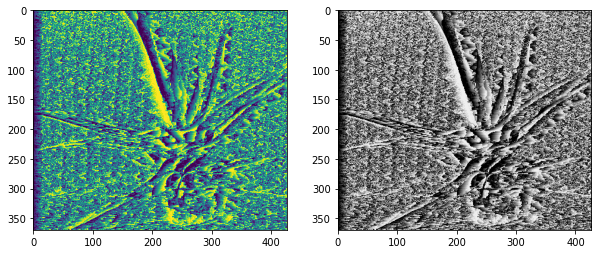

In [ ]:
PWM = pixel_wise(left_image, right_image, disparity_range, compute_type="l1")
PWM.matching()

## PROBLEM 2

In [ ]:
class window_based:
    def __init__(
        self,
        left_img,
        right_img,
        disparity_range,
        compute_type="l1",
        kernal_size=5,
        save_result=True,
    ):
        factory = Factory()
        self.left_img = left_img
        self.right_img = right_img
        self.disparity_range = disparity_range
        self.compute_type = factory.getDistance(compute_type)
        self.kernal_size = kernal_size
        self.save_result = save_result
        self.index = 0

    def matching(self):
        # Take 2 pictures, left and right. Then convert those to grayscale.
        left = cv2.imread(self.left_img, 0).astype(np.float32)
        right = cv2.imread(self.right_img, 0).astype(np.float32)

        # Take 2 parameters, height and width of the right picture
        height, width = left.shape[:2]

        kernal_half = int((self.kernal_size - 1) / 2)
        self.disparity_map = np.zeros((height, width), np.uint8)
        scale = 255 / self.disparity_range
        print(
            "COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH "
            + self.compute_type.name.capitalize()
            + "..."
        )

        for y in range(kernal_half, height - kernal_half):
            for x in range(kernal_half, width - kernal_half):
                d_val = 0
                cost_min = 255 if self.compute_type == "l1" else 255**2

                # Iteratively calculate cost in disparity range and retrieve the argument that make cost
                # function reach the optimal value
                for d in range(self.disparity_range):
                    ssd = 0
                    ssd_temp = 0

                    for v in range(-kernal_half, kernal_half + 1):
                        for u in range(-kernal_half, kernal_half + 1):
                            ssd_temp = 255 if self.compute_type == "l1" else 255**2
                            if (x + u - d) >= 0:
                                ssd_temp = self.compute_type.getDistance(
                                    int(left[y + v, x + u]),
                                    int(right[y + v, x + u - d]),
                                )
                            ssd += ssd_temp

                    # Update cost_min
                    if ssd < cost_min:
                        cost_min = ssd
                        d_val = d

                self.disparity_map[y, x] = d_val * scale

        self.saveResult(self.save_result)
        print("DONE")
        # cv2_imshow(self.disparity_map)
        self.color_map = cv2.cvtColor(self.disparity_map, cv2.COLOR_GRAY2BGR)
        fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
        a1.imshow(self.disparity_map)
        a2.imshow(self.color_map)
        plt.show()

    def saveResult(self, result):
        filename_d = (
            "pwm"
            + "_grayscale_"
            + self.compute_type.name
            + str(hash("pwm" + self.compute_type.name))
            + "_"
            + str(self.index)
            + ".png"
        )
        if result == True:
            print("...SAVING RESULT...")
            cv2.imwrite(filename_d, self.disparity_map)
        self.index += 1

COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH L1 distance method...
...SAVING RESULT...
DONE


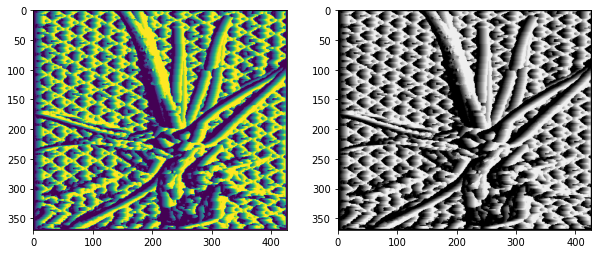

In [ ]:
right_image_2 = IMG_PATH + "Aloe_right_2.png"
WBM = window_based(left_image, right_image_2, disparity_range)
WBM.matching()

## PROBLEM 3

COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH L1 distance method...
...SAVING RESULT...
DONE


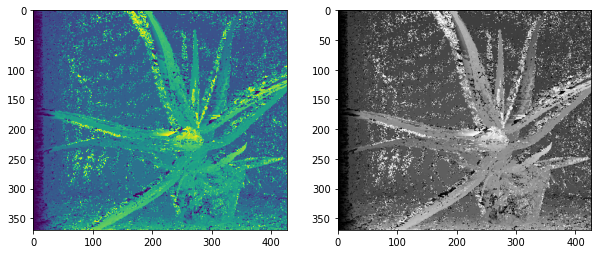

In [ ]:
WBM2 = window_based(left_image, right_image, disparity_range=64, kernal_size=3)
WBM2.matching()

As can be seen, the grayscale picture which has disparity_range=64 and kernal_size=3 compares to the grayscale picture which has disparity_range=16 and kernal_size=5, the former gives the image which more that close to the original. 

## PROBLEM 4

In [ ]:
class window_based_4:
    def __init__(
        self,
        left_img,
        right_img,
        disparity_range,
        compute_type="l1",
        kernal_size=5,
        save_result=True,
    ):
        factory = Factory()
        self.left_img = left_img
        self.right_img = right_img
        self.disparity_range = disparity_range
        self.compute_type = factory.getDistance(compute_type)
        self.kernal_size = kernal_size
        self.save_result = save_result
        self.index = 0

    def matching(self):
        # Take 2 pictures, left and right. Then convert those to grayscale.
        left = cv2.imread(self.left_img, 0).astype(np.float32)
        right = cv2.imread(self.right_img, 0).astype(np.float32)

        # Take 2 parameters, height and width of the right picture
        height, width = left.shape[:2]

        kernal_half = int((self.kernal_size - 1) / 2)
        self.disparity_map = np.zeros((height, width), np.uint8)
        scale = 255 / self.disparity_range
        print(
            "COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH "
            + self.compute_type.name.capitalize()
            + "..."
        )

        for y in range(kernal_half, height - kernal_half):
            for x in range(kernal_half, width - kernal_half):
                d_val = 0
                cost_optimal = -1

                # Iteratively calculate cost in disparity range and retrieve the argument that make cost
                # function reach the optimal value
                for d in range(self.disparity_range):
                    j = x - d
                    cost = -1
                    if j - kernal_half >= 0:
                        wl = left[
                            (y - kernal_half) : (y + kernal_half) + 1,
                            (x - kernal_half) : (x + kernal_half) + 1,
                        ]
                        wr = right[
                            (y - kernal_half) : (y + kernal_half) + 1,
                            (j - kernal_half) : (j + kernal_half) + 1,
                        ]
                        cost = self.cosine_similarity(wl.flatten(), wr.flatten())

                    if cost > cost_optimal:
                        cost_optimal = cost
                        d_val = d

                self.disparity_map[y, x] = d_val * scale

        self.saveResult(self.save_result)
        print("DONE")
        # cv2_imshow(self.disparity_map)
        self.color_map = cv2.cvtColor(self.disparity_map, cv2.COLOR_GRAY2BGR)
        fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
        a1.imshow(self.disparity_map)
        a2.imshow(self.color_map)
        plt.show()

    def cosine_similarity(self, vect1, vect2):
        vect1 = np.array(vect1)
        vect2 = np.array(vect2)
        numerator = np.dot(vect1, vect2)
        denominator = np.linalg.norm(vect1) * np.linalg.norm(vect2)
        return numerator / denominator

    def saveResult(self, result):
        filename_d = (
            "wbm4"
            + "_grayscale_"
            + self.compute_type.name
            + str(hash("pwm" + self.compute_type.name))
            + "_"
            + str(self.index)
            + ".png"
        )
        if result == True:
            print("...SAVING RESULT...")
            cv2.imwrite(filename_d, self.disparity_map)
        self.index += 1

COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH L1 distance method...
...SAVING RESULT...
DONE


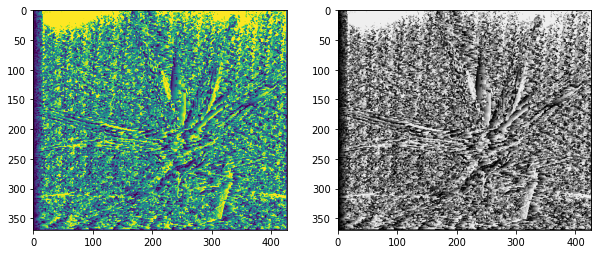

In [ ]:
WBM4 = window_based_4(left_image, right_image, disparity_range=16, kernal_size=3)
WBM4.matching()

## PROBLEM 5

In [ ]:
class window_based_5:
    def __init__(
        self,
        left_img,
        right_img,
        disparity_range,
        compute_type="l1",
        kernal_size=5,
        save_result=True,
    ):
        factory = Factory()
        self.left_img = left_img
        self.right_img = right_img
        self.disparity_range = disparity_range
        self.compute_type = factory.getDistance(compute_type)
        self.kernal_size = kernal_size
        self.save_result = save_result
        self.index = 0

    def matching(self):
        # Take 2 pictures, left and right. Then convert those to grayscale.
        left = cv2.imread(self.left_img, 0).astype(np.float32)
        right = cv2.imread(self.right_img, 0).astype(np.float32)

        # Take 2 parameters, height and width of the right picture
        height, width = left.shape[:2]

        kernal_half = int((self.kernal_size - 1) / 2)
        self.disparity_map = np.zeros((height, width), np.uint8)
        scale = 255 / self.disparity_range
        print(
            "COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH "
            + self.compute_type.name.capitalize()
            + "..."
        )

        for y in range(kernal_half, height - kernal_half):
            for x in range(kernal_half, width - kernal_half):
                d_val = 0
                cost_optimal = -1

                # Iteratively calculate cost in disparity range and retrieve the argument that make cost
                # function reach the optimal value
                for d in range(self.disparity_range):
                    j = x - d
                    cost = -1
                    if j - kernal_half >= 0:
                        wl = left[
                            (y - kernal_half) : (y + kernal_half) + 1,
                            (x - kernal_half) : (x + kernal_half) + 1,
                        ]
                        wr = right[
                            (y - kernal_half) : (y + kernal_half) + 1,
                            (j - kernal_half) : (j + kernal_half) + 1,
                        ]
                        cost = self.correlation(wl.flatten(), wr.flatten())

                    if cost > cost_optimal:
                        cost_optimal = cost
                        d_val = d

                self.disparity_map[y, x] = d_val * scale

        self.saveResult(self.save_result)
        print("DONE")
        # cv2_imshow(self.disparity_map)
        self.color_map = cv2.cvtColor(self.disparity_map, cv2.COLOR_GRAY2BGR)
        fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
        a1.imshow(self.disparity_map)
        a2.imshow(self.color_map)
        plt.show()

    def correlation(self, vect1, vect2):
        vect1_mean = np.mean(vect1)
        vect2_mean = np.mean(vect2)
        numerator = np.dot(vect1 - vect1_mean, vect2 - vect2_mean)
        denominator = np.linalg.norm(vect1 - vect1_mean) * np.linalg.norm(
            vect2 - vect2_mean
        )
        return numerator / denominator

    def saveResult(self, result):
        filename_d = (
            "wbm4"
            + "_grayscale_"
            + self.compute_type.name
            + str(hash("pwm" + self.compute_type.name))
            + "_"
            + str(self.index)
            + ".png"
        )
        if result == True:
            print("...SAVING RESULT...")
            cv2.imwrite(filename_d, self.disparity_map)
        self.index += 1

COMPUTE DISPARITY MAP USING WINDOW-BASED MATCHING WITH L1 distance method...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in float_scalars


...SAVING RESULT...
DONE


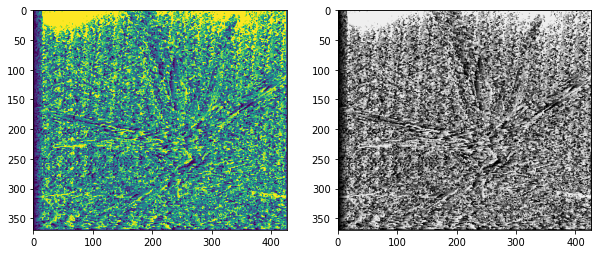

In [ ]:
WDM5 = window_based_5(left_image, right_image, disparity_range=16, kernal_size=3)
WDM5.matching()